In [1]:
!pip install patchify
!pip install psutil

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify

import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import fiona
from shapely.geometry import shape
import cv2
from pytorch_segmentation.inference import mosaic_to_raster
from pytorch_segmentation.data.inference_dataset import SatInferenceDataset
from pytorch_segmentation.utils.helper import shapes_intersecting_with_raster
#from pytorch_segmentation.utils.preprocessing import unpatchify,pad_image_topleft


seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


patch_size = [256,256,3] # [x,y,bands]
overlap = 128
padding = 64

bval = (255,255,255)
nworkers = 4
bs = 16

dataset_path = "data/datasets/inference_data.pkl"
data_path = "/home/jovyan/work/satellite_data/tmp/2018.vrt"
#data_path = "/home/jovyan/work/satellite_data/tmp/27/2018_cog.tif"
shape_path = "data/areas/test_small/test_area.shp"
#shape_path = "data/areas/test/boundary.shp"

model_path = "saved_models/unet_12_05_2022_145256.pth" #unet_29_04_2022_111333.pth" #unet_28_04_2022_160327.pth" #unet_07_04_2022_094905.pth" #unet_15_03_2022_071331.pth" #unet_24_03_2022_064749.pth

In [3]:
#data_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/V2/Training_Images_RGB_v2/rwanda_v2.vrt"
#data_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/images/test/test_rwanda.vrt"
data_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/Training_Images_RGB/rwanda.vrt"

shape_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/Training_rectangles/rectangles_updated.shp"
#shape_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/V2/Training_rectangles_v2/rectangles_model_29_v2.shp"
#shape_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/test"

# 1. Data Loading and Preprocessing

In [4]:
shape_idxs = shapes_intersecting_with_raster(shape_path,data_path)
#shape_idxs = None

In [5]:

dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,shape_idx=shape_idxs,overlap=128,padding=64)
shapes = dataset.shapes.copy()
dataset.save(dataset_path)

#del dataset


# 2. UNet 


# 2.2 Unet

In [6]:
from pytorch_segmentation.models import UNet
net = UNet(n_channels=patch_size[2], n_classes=2, bilinear=False)
net.load_state_dict(torch.load(model_path,map_location="cpu"))
#net = net.to(device)
net.eval();



# Multi Process Queue In-Memory

In [7]:
from pytorch_segmentation.inference import mosaic_to_raster
mosaic_to_raster(dataset_path,shapes,net,"data/out/",device_ids=[0,1,2,3],
                bs=150,pin_memory=True,num_workers=5)

Total number of shapes:  82
Shape:  0
Queue PID:  32300


  0%|          | 0/112 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 26%|██▌       | 29/112 [00:05<00:10,  7.58it/s]

DONE  0
DONE  1


100%|██████████| 112/112 [00:05<00:00, 19.95it/s]


DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_1.tif in 0.054 seconds
Shape:  1
Queue PID:  32300


  0%|          | 0/126 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 126/126 [00:05<00:00, 22.81it/s]


DONE  2
DONE  1
DONE  0
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_2.tif in 0.057 seconds
Shape:  2
Queue PID:  32300


  0%|          | 0/204 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 204/204 [00:05<00:00, 34.76it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_3.tif in 0.045 seconds
Shape:  3
Queue PID:  32300


  0%|          | 0/126 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 126/126 [00:05<00:00, 22.90it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_4.tif in 0.038 seconds
Shape:  4
Queue PID:  32300


  0%|          | 0/476 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 3
Start GPU: 1


 25%|██▌       | 120/476 [00:06<00:14, 24.25it/s]

DONE  0


100%|██████████| 476/476 [00:07<00:00, 66.72it/s] 


DONE  2
DONE  3
DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_5.tif in 0.072 seconds
Shape:  5
Queue PID:  32300


  0%|          | 0/96 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 96/96 [00:05<00:00, 17.76it/s]

DONE  0
DONE  3
DONE  1
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_6.tif in 0.039 seconds
Shape:  6
Queue PID:  32300


  0%|          | 0/126 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 26%|██▌       | 33/126 [00:05<00:10,  8.60it/s]

DONE  0
DONE  1
DONE  3


100%|██████████| 126/126 [00:05<00:00, 22.76it/s]


DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_7.tif in 0.043 seconds
Shape:  7
Queue PID:  32300


  0%|          | 0/117 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 117/117 [00:05<00:00, 21.42it/s]


DONE  0
DONE  2
DONE  1
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_8.tif in 0.043 seconds
Shape:  8
Queue PID:  32300


  0%|          | 0/104 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 104/104 [00:05<00:00, 18.95it/s]

DONE  1
DONE  0
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_9.tif in 0.054 seconds
Shape:  9
Queue PID:  32300


  0%|          | 0/324 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 324/324 [00:06<00:00, 49.66it/s]


DONE  0
DONE  2
DONE  1
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_10.tif in 0.065 seconds
Shape:  10
Queue PID:  32300


  0%|          | 0/18 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


100%|██████████| 18/18 [00:05<00:00,  3.59it/s]

DONE  0
DONE  2
DONE  1
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_11.tif in 0.093 seconds
Shape:  11
Queue PID:  32300


  0%|          | 0/300 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 300/300 [00:06<00:00, 46.01it/s]


DONE  1
DONE  0
DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_12.tif in 0.056 seconds
Shape:  12
Queue PID:  32300


  0%|          | 0/70 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 70/70 [00:05<00:00, 13.37it/s]


DONE  0
DONE  1
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_13.tif in 0.043 seconds
Shape:  13
Queue PID:  32300


  0%|          | 0/91 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 77%|███████▋  | 70/91 [00:05<00:01, 20.83it/s]

DONE  0
DONE  1
DONE  2


100%|██████████| 91/91 [00:05<00:00, 16.97it/s]


DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_14.tif in 0.038 seconds
Shape:  14
Queue PID:  32300


  0%|          | 0/1000 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 70%|███████   | 701/1000 [00:08<00:01, 170.44it/s]

DONE  0


100%|██████████| 1000/1000 [00:08<00:00, 117.43it/s]

DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_15.tif in 0.109 seconds
Shape:  15
Queue PID:  32300


  0%|          | 0/104 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 104/104 [00:05<00:00, 19.29it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_16.tif in 0.041 seconds
Shape:  16
Queue PID:  32300


  0%|          | 0/40 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 3
Start GPU: 1
Start GPU: 2


100%|██████████| 40/40 [00:05<00:00,  7.54it/s]

DONE  0
DONE  3
DONE  1
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_17.tif in 0.029 seconds
Shape:  17
Queue PID:  32300


  0%|          | 0/24 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 79%|███████▉  | 19/24 [00:04<00:00,  6.44it/s]

DONE  0
DONE  1
DONE  3


100%|██████████| 24/24 [00:04<00:00,  4.88it/s]


DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_18.tif in 0.026 seconds
Shape:  18
Queue PID:  32300


  0%|          | 0/30 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 30/30 [00:05<00:00,  5.90it/s]

DONE  1
DONE  0
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_19.tif in 0.019 seconds
Shape:  19
Queue PID:  32300


  0%|          | 0/25 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 25/25 [00:05<00:00,  4.92it/s]


DONE  3
DONE  2
DONE  1
DONE  0


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_20.tif in 0.017 seconds
Shape:  20
Queue PID:  32300


  0%|          | 0/35 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 35/35 [00:05<00:00,  6.93it/s]


DONE  0
DONE  2
DONE  1
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_21.tif in 0.018 seconds
Shape:  21
Queue PID:  32300


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_22.tif in 0.017 seconds
Shape:  22
Queue PID:  32300


  0%|          | 0/12 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


DONE  1
DONE  2
DONE  0
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_23.tif in 0.022 seconds
Shape:  23
Queue PID:  32300


  0%|          | 0/432 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 432/432 [00:07<00:00, 61.48it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_24.tif in 0.113 seconds
Shape:  24
Queue PID:  32300


  0%|          | 0/12 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


 83%|████████▎ | 10/12 [00:04<00:00,  2.75it/s]

DONE  0
DONE  1
DONE  2


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_25.tif in 0.023 seconds
Shape:  25
Queue PID:  32300


  0%|          | 0/196 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 3
Start GPU: 2


 26%|██▌       | 50/196 [00:05<00:12, 12.16it/s]

DONE  0


100%|██████████| 196/196 [00:05<00:00, 33.13it/s]


DONE  1
DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_26.tif in 0.044 seconds
Shape:  26
Queue PID:  32300


  0%|          | 0/108 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 108/108 [00:05<00:00, 20.26it/s]


DONE  0
DONE  2
DONE  3
DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_27.tif in 0.033 seconds
Shape:  27
Queue PID:  32300


  0%|          | 0/12 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_28.tif in 0.021 seconds
Shape:  28
Queue PID:  32300


  0%|          | 0/24 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 3
Start GPU: 2


100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


DONE  0
DONE  1
DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_29.tif in 0.025 seconds
Shape:  29
Queue PID:  32300


  0%|          | 0/8 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


DONE  3
DONE  1
DONE  0
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_30.tif in 0.019 seconds
Shape:  30
Queue PID:  32300


  0%|          | 0/35 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 35/35 [00:05<00:00,  6.85it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_31.tif in 0.034 seconds
Shape:  31
Queue PID:  32300


  0%|          | 0/12 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


DONE  0
DONE  1
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_32.tif in 0.040 seconds
Shape:  32
Queue PID:  32300


  0%|          | 0/270 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 270/270 [00:06<00:00, 43.24it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_33.tif in 0.054 seconds
Shape:  33
Queue PID:  32300


  0%|          | 0/192 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 192/192 [00:05<00:00, 32.75it/s]


DONE  0
DONE  1
DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_34.tif in 0.051 seconds
Shape:  34
Queue PID:  32300


  0%|          | 0/50 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 50/50 [00:05<00:00,  9.69it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_35.tif in 0.032 seconds
Shape:  35
Queue PID:  32300


  0%|          | 0/180 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 2
Start GPU: 3
Start GPU: 0


100%|██████████| 180/180 [00:05<00:00, 30.57it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_36.tif in 0.052 seconds
Shape:  36
Queue PID:  32300


  0%|          | 0/460 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 460/460 [00:07<00:00, 65.44it/s]

DONE  0
DONE  3
DONE  1
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_37.tif in 0.069 seconds
Shape:  37
Queue PID:  32300


  0%|          | 0/45 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 3
Start GPU: 2


100%|██████████| 45/45 [00:05<00:00,  8.70it/s]

DONE  0
DONE  3
DONE  2
DONE  1



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_38.tif in 0.040 seconds
Shape:  38
Queue PID:  32300


  0%|          | 0/240 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 240/240 [00:06<00:00, 39.30it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_39.tif in 0.053 seconds
Shape:  39
Queue PID:  32300


  0%|          | 0/160 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


100%|██████████| 160/160 [00:05<00:00, 28.25it/s]


DONE  2
DONE  0
DONE  3
DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_40.tif in 0.048 seconds
Shape:  40
Queue PID:  32300


  0%|          | 0/63 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 63/63 [00:05<00:00, 12.37it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_41.tif in 0.034 seconds
Shape:  41
Queue PID:  32300


  0%|          | 0/91 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 91/91 [00:05<00:00, 17.00it/s]

DONE  0
DONE  3
DONE  1
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_42.tif in 0.043 seconds
Shape:  42
Queue PID:  32300


  0%|          | 0/128 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 128/128 [00:05<00:00, 23.12it/s]

DONE  0
DONE  3
DONE  1
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_43.tif in 0.040 seconds
Shape:  43
Queue PID:  32300


  0%|          | 0/276 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 3
Start GPU: 2


100%|██████████| 276/276 [00:06<00:00, 44.10it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_44.tif in 0.056 seconds
Shape:  44
Queue PID:  32300


  0%|          | 0/308 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


 25%|██▌       | 78/308 [00:06<00:13, 17.63it/s]

DONE  0
DONE  2
DONE  3


100%|██████████| 308/308 [00:06<00:00, 47.02it/s]


DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_45.tif in 0.056 seconds
Shape:  45
Queue PID:  32300


  0%|          | 0/432 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 432/432 [00:07<00:00, 61.61it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_46.tif in 0.075 seconds
Shape:  46
Queue PID:  32300


  0%|          | 0/208 [00:00<?, ?it/s]

Start GPU: 2
Start GPU: 0
Start GPU: 1
Start GPU: 3


100%|██████████| 208/208 [00:05<00:00, 34.79it/s]


DONE  2
DONE  0
DONE  1
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_47.tif in 0.055 seconds
Shape:  47
Queue PID:  32300


  0%|          | 0/260 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


 89%|████████▉ | 231/260 [00:06<00:00, 68.78it/s]

DONE  0
DONE  3
DONE  2


100%|██████████| 260/260 [00:06<00:00, 42.19it/s]


DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_48.tif in 0.050 seconds
Shape:  48
Queue PID:  32300


  0%|          | 0/63 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 63/63 [00:05<00:00, 12.22it/s]


DONE  1
DONE  3
DONE  0
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_49.tif in 0.038 seconds
Shape:  49
Queue PID:  32300


  0%|          | 0/140 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


 76%|███████▌  | 106/140 [00:05<00:01, 32.98it/s]

DONE  0
DONE  2
DONE  1


100%|██████████| 140/140 [00:05<00:00, 24.65it/s]


DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_50.tif in 0.033 seconds
Shape:  50
Queue PID:  32300


  0%|          | 0/91 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 3
Start GPU: 2


100%|██████████| 91/91 [00:05<00:00, 16.87it/s]


DONE  3
DONE  2
DONE  0
DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_51.tif in 0.039 seconds
Shape:  51
Queue PID:  32300


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_52.tif in 0.039 seconds
Shape:  52
Queue PID:  32300


  0%|          | 0/28 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 28/28 [00:05<00:00,  5.39it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_53.tif in 0.050 seconds
Shape:  53
Queue PID:  32300


  0%|          | 0/209 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


 97%|█████████▋| 203/209 [00:05<00:00, 63.42it/s]

DONE  0
DONE  2
DONE  1


100%|██████████| 209/209 [00:05<00:00, 35.40it/s]


DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_54.tif in 0.049 seconds
Shape:  54
Queue PID:  32300


  0%|          | 0/48 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 48/48 [00:05<00:00,  9.56it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_55.tif in 0.039 seconds
Shape:  55
Queue PID:  32300


  0%|          | 0/54 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 3
Start GPU: 2


100%|██████████| 54/54 [00:05<00:00, 10.49it/s]


DONE  0
DONE  3
DONE  1
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_56.tif in 0.025 seconds
Shape:  56
Queue PID:  32300


  0%|          | 0/48 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


100%|██████████| 48/48 [00:05<00:00,  9.35it/s]

DONE  0
DONE  2
DONE  3
DONE  1



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_57.tif in 0.038 seconds
Shape:  57
Queue PID:  32300


  0%|          | 0/98 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 77%|███████▋  | 75/98 [00:05<00:01, 19.79it/s]

DONE  0
DONE  1
DONE  2


100%|██████████| 98/98 [00:05<00:00, 18.16it/s]


DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_58.tif in 0.037 seconds
Shape:  58
Queue PID:  32300


  0%|          | 0/24 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


DONE  2
DONE  0
DONE  1
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_59.tif in 0.046 seconds
Shape:  59
Queue PID:  32300


  0%|          | 0/63 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 76%|███████▌  | 48/63 [00:05<00:01, 13.01it/s]

DONE  1
DONE  0
DONE  3


100%|██████████| 63/63 [00:05<00:00, 12.04it/s]


DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_60.tif in 0.026 seconds
Shape:  60
Queue PID:  32300


  0%|          | 0/28 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 3
Start GPU: 2


100%|██████████| 28/28 [00:05<00:00,  5.59it/s]


DONE  0
DONE  1
DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_61.tif in 0.023 seconds
Shape:  61
Queue PID:  32300


  0%|          | 0/28 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


DONE  0
DONE  1
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_62.tif in 0.022 seconds
Shape:  62
Queue PID:  32300


  0%|          | 0/45 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 45/45 [00:05<00:00,  8.61it/s]

DONE  1
DONE  0
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_63.tif in 0.035 seconds
Shape:  63
Queue PID:  32300


  0%|          | 0/72 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 72/72 [00:05<00:00, 13.80it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_64.tif in 0.025 seconds
Shape:  64
Queue PID:  32300


  0%|          | 0/84 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 84/84 [00:05<00:00, 15.56it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_65.tif in 0.025 seconds
Shape:  65
Queue PID:  32300


  0%|          | 0/16 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 2
Start GPU: 1
Start GPU: 3


 31%|███▏      | 5/16 [00:04<00:08,  1.37it/s]

DONE  0


100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


DONE  2
DONE  1
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_66.tif in 0.034 seconds
Shape:  66
Queue PID:  32300


  0%|          | 0/54 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


 54%|█████▎    | 29/54 [00:05<00:03,  8.00it/s]

DONE  0
DONE  1
DONE  2


100%|██████████| 54/54 [00:05<00:00, 10.48it/s]


DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_67.tif in 0.053 seconds
Shape:  67
Queue PID:  32300


  0%|          | 0/72 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 3
Start GPU: 2


100%|██████████| 72/72 [00:05<00:00, 13.71it/s]

DONE  0
DONE  3
DONE  1
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_68.tif in 0.026 seconds
Shape:  68
Queue PID:  32300


  0%|          | 0/45 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 45/45 [00:05<00:00,  8.76it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_69.tif in 0.035 seconds
Shape:  69
Queue PID:  32300


  0%|          | 0/84 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 84/84 [00:05<00:00, 15.61it/s]


DONE  1
DONE  0
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_70.tif in 0.032 seconds
Shape:  70
Queue PID:  32300


  0%|          | 0/16 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


DONE  0
DONE  1
DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_71.tif in 0.025 seconds
Shape:  71
Queue PID:  32300


  0%|          | 0/112 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 112/112 [00:05<00:00, 20.72it/s]

DONE  0
DONE  2
DONE  1
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_72.tif in 0.047 seconds
Shape:  72
Queue PID:  32300


  0%|          | 0/180 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 3
Start GPU: 2


100%|██████████| 180/180 [00:05<00:00, 31.03it/s]


DONE  2
DONE  1
DONE  0
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_73.tif in 0.065 seconds
Shape:  73
Queue PID:  32300


  0%|          | 0/60 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 60/60 [00:05<00:00, 11.73it/s]


DONE  0
DONE  3
DONE  2
DONE  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_74.tif in 0.025 seconds
Shape:  74
Queue PID:  32300


  0%|          | 0/1085 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 1085/1085 [00:08<00:00, 124.35it/s]

DONE  2
DONE  1
DONE  0
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_75.tif in 0.113 seconds
Shape:  75
Queue PID:  32300


  0%|          | 0/897 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


 75%|███████▌  | 676/897 [00:08<00:01, 175.19it/s]

DONE  0
DONE  1


100%|██████████| 897/897 [00:08<00:00, 105.76it/s]


DONE  3
DONE  2


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_76.tif in 0.102 seconds
Shape:  76
Queue PID:  32300


  0%|          | 0/88 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 88/88 [00:05<00:00, 16.51it/s]

DONE  0
DONE  1
DONE  2
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_77.tif in 0.032 seconds
Shape:  77
Queue PID:  32300


  0%|          | 0/126 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 126/126 [00:05<00:00, 23.08it/s]

DONE  0
DONE  1
DONE  3
DONE  2



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_78.tif in 0.045 seconds
Shape:  78
Queue PID:  32300


  0%|          | 0/513 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 513/513 [00:07<00:00, 69.41it/s]

DONE  1
DONE  2
DONE  3
DONE  0



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_79.tif in 0.070 seconds
Shape:  79
Queue PID:  32300


  0%|          | 0/154 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 154/154 [00:05<00:00, 27.36it/s]


DONE  0
DONE  1
DONE  2
DONE  3


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use

INFO: Written data/out/rectangles_updated_80.tif in 0.047 seconds
Shape:  80
Queue PID:  32300


  0%|          | 0/384 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1
Start GPU: 2
Start GPU: 3


100%|██████████| 384/384 [00:06<00:00, 56.87it/s]

DONE  0
DONE  2
DONE  1
DONE  3



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_81.tif in 0.058 seconds
Shape:  81
Queue PID:  32300


  0%|          | 0/45 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0
Start GPU: 2
Start GPU: 3


100%|██████████| 45/45 [00:05<00:00,  8.63it/s]

DONE  1
DONE  2
DONE  3
DONE  0



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not us

INFO: Written data/out/rectangles_updated_82.tif in 0.025 seconds
Created Tif file in 116.19590973854065 seconds: data/out/mask_13_05_2022_155359.tif


# Backlog

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [ ]:
from pytorch_segmentation.models.unet_simple import UNet

net = UNet(patch_size[2],2)
net = net.load_state_dict(torch.load(model_path)).to(device)
net.eval()

In [11]:
output = []
#out = net(X.to(device))
for i,batch in enumerate(dl):
    x = batch.to(device)#[0].to(device)
    out = net(x)
    out = F.softmax(out,dim=1)
    out = torch.argmax(out,dim=1)
    out = out.cpu().numpy().astype("uint8")
    output.append(out)
imgs = np.vstack(output)

In [8]:
out_image = unpatchify(imgs,patches.shape[:2],pad)
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":1,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open(out_file, "w", **out_meta) as dest:
    dest.write(out_image)

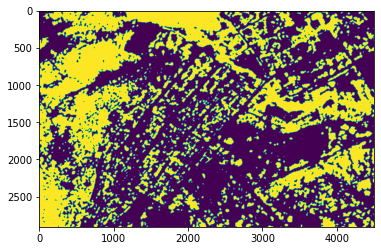

In [9]:
show(out_image);

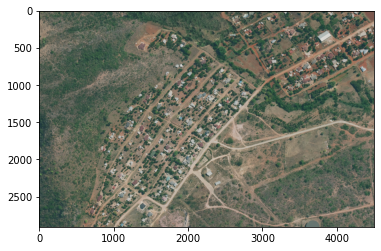

In [10]:
show(sat_patch_arr);

In [16]:
out_image = sat_patch_arr
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":3,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open('data/out/raster.tif', "w", **out_meta) as dest:
    dest.write(out_image)

In [6]:
import fiona 
from shapely import geometry
shp = fiona.open("data/areas/test_small/test_area.shp")
sat = rasterio.open("/home/jovyan/work/satellite_data/tmp/2018.vrt")
geom =  geometry.shape(shp[0]["geometry"])
win = from_bounds(*geom.bounds,sat.transform)

In [33]:
(4509-128+64) / 128

34.7265625

In [34]:
(512-128+64) / 128

3.5

In [156]:
(10-1+1/ 1)

10.0

In [5]:
dataset.shapes

,shape_id,transform,padding,start_idx,grid_shape,name,width,height,sat_meta
0,0,"(2.3064348774137157e-06, 0.0, 30.5051843459955...","(64, 100, 64, 40)",0,"[23, 35]",test_small_1,4504.537662,2908.038913,"{'driver': 'VRT', 'dtype': 'uint8', 'nodata': ..."


In [17]:

x_rest = (int(win.width)-128+2*padding) % 128
y_rest = (int(win.height)-128+2*padding) % 128

In [18]:
x_rest

24

In [19]:
y_rest

92

In [35]:
from rasterio.windows import Window
def patchify_window(window,sat_image,patch_size,overlap,padding):
        step_size = patch_size[0] - overlap
        w,h = window.width,window.height
        
        max_x = int(np.ceil((window.width-overlap+padding) / step_size  ))
        max_y = int(np.ceil((window.height-overlap+padding) / step_size ))

        
        n_y = 0#int((h-patch_size[0]+2*padding) // step_size)

        w_list = []
        y = window.row_off-padding
        i = 0
        for _ in range(max_y):
            n_x = 0 #int((w-patch_size[0]+2*padding) // step_size)
            x = window.col_off-padding
            for _ in range(max_x):
                w_patch = patch_size[0]
                h_patch = patch_size[0]
                w = Window(col_off=x,row_off=y,width=w_patch,height=h_patch)
                #transform = satellite_img.window_transform(w)
                #w_list.append({"window":w})#,"transform":transform}) #TODO Transform really required?
                arr = sat_image.read(window=w)#[0,:,:]
                #arr = arr.astype(np.int64)
                #arr[:] = i
                w_list.append(arr)
                x += step_size
                n_x += 1
                i += 1
                #print(i)
            n_y += 1
            y += step_size

        grid_shape = [n_y,n_x]
        
        return w_list,grid_shape

In [59]:
def unpatchify_window_batch(memfile,patches,start_idx,grid_shape,padding):
    #So far only for one shape at once possible!
    ny,nx = grid_shape
    ypad,ypad_extra,xpad,xpad_extra = padding
    #xpad_extra = xpad + xpad_extra
    #ypad_extra = ypad + ypad_extra


    patch_size = patches[0].shape[1:]
    grid = np.arange(ny*nx).reshape(ny,nx)
    
    y,x = np.where(grid == start_idx)

    col_off = (patch_size[0] - xpad*2) * x  
    row_off = (patch_size[1] - ypad*2) * y
    for i in range(len(patches)):
        img = patches[i]

        co,ro = 0,0
        if (x != nx-1) and (y != ny-1):
            cropped_img = img[:,ypad:img.shape[1]-ypad,xpad:img.shape[2]-xpad]
            co = cropped_img.shape[2]
            x += 1
        elif (x == nx-1) and (y != ny-1):
            cropped_img = img[:,ypad:img.shape[1]-ypad,xpad:img.shape[2]-xpad_extra]
            ro = cropped_img.shape[1]
            co = -col_off
            x = 0
            y += 1
        elif (x != nx-1) and (y == ny-1):
            cropped_img = img[:,ypad:img.shape[1]-ypad_extra,xpad:img.shape[2]-xpad]
            co = cropped_img.shape[2]
            x += 1
        elif (x == nx-1) and (y == ny-1):
            cropped_img = img[:,ypad:img.shape[1]-ypad_extra,xpad:img.shape[2]-xpad_extra]
        win = Window(row_off=row_off,col_off=col_off,
                        width=cropped_img.shape[2],height=cropped_img.shape[1])

        memfile.write(cropped_img,window=win)
        col_off += co
        row_off += ro

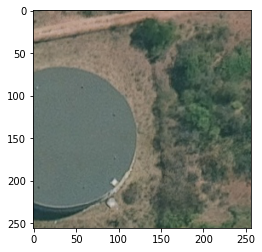

<AxesSubplot:>

In [173]:
show(patches[-6])

In [37]:
patches,grid = patchify_window(win,sat,[256,256],128,64)

In [38]:
grid

[23, 35]

In [60]:
with rasterio.Env(GDAL_CACHEMAX=10024):
    memory = rasterio.MemoryFile()

    height = 2908
    width = 4504
    out_meta = {"driver": "GTiff",
                    "overwrite":True,
                    "count":3,
                    "height": height,
                    "width": width,
                    "compress":"DEFLATE",
                    "tiled":True,
                    "blockxsize":256, 
                    "blockysize":256,
                    "BIGTIFF":'YES',
                    #"predictor":2,
                    "NUM_THREADS":"ALL_CPUS",
                    "dtype":"int32"}
    mfile = memory.open(**out_meta)
    unpatchify_window_batch(mfile,patches,0,grid,[64, 100, 64, 40])
    

In [185]:
mfile.read().shape

(3, 2908, 4504)

In [182]:
dataset.shapes

,shape_id,transform,padding,start_idx,grid_shape,name,width,height,sat_meta
0,0,"(2.3064348774137157e-06, 0.0, 30.5051843459955...","(64, 100, 64, 40)",0,"[23, 35]",test_small_1,4504.537662,2908.038913,"{'driver': 'VRT', 'dtype': 'uint8', 'nodata': ..."


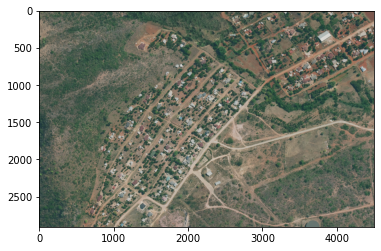

<AxesSubplot:>

In [61]:
show(mfile.read())

In [116]:
a = mfile.read()

In [101]:
a.shape

(1, 2908, 4504)

In [54]:
len(patches)

770

In [104]:
patches[-1]

array([[769, 769, 769, ..., 769, 769, 769],
       [769, 769, 769, ..., 769, 769, 769],
       [769, 769, 769, ..., 769, 769, 769],
       ...,
       [769, 769, 769, ..., 769, 769, 769],
       [769, 769, 769, ..., 769, 769, 769],
       [769, 769, 769, ..., 769, 769, 769]])

In [123]:
a[:,-32:-1,-32:-1]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
dataset.shapes

,shape_id,transform,padding,start_idx,grid_shape,name,width,height,sat_meta
0,0,"(2.3064348774137157e-06, 0.0, 30.5051843459955...","(64, 100, 64, 40)",0,"[23, 35]",test_small_1,4504.537662,2908.038913,"{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'..."


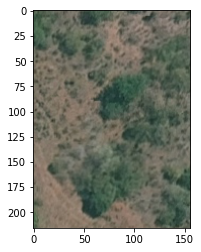

<AxesSubplot:>

In [28]:
show(dataset[-1][0][:,:216,:156])

## Single Process 

In [ ]:
mosaic_to_raster(dataset,net,"data/out/",device_ids=[0,1,2,3,4],bs=650,pin_memory=True,num_workers=20)

# Multi Process

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp
mosaic_to_raster_mp(dataset_path,net,"data/out/",device_ids=[0,2,3,4],bs=150,pin_memory=True,num_workers=8)

## Multi Process Queue

In [4]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp_queue
mosaic_to_raster_mp_queue(dataset_path,net,"data/out/",mmap_shape=(len_dataset,256,256),device_ids=[0,1,2,3,4],
                          bs=150,pin_memory=True,num_workers=10)

ModuleNotFoundError: No module named 'pytorch_segmentation.utils.postprocessing'